### キャッシュファイルの内容
- 複数のシミュレーション条件（Vtip, Rtip, Htip）ごとの水平方向ポテンシャル分布データ
- 各キャッシュファイルには以下の配列が格納されています：
    - `Vtip`, `Rtip`, `Htip`: 各パラメータの値リスト
    - `r`: 距離（nm）
    - `data`: ポテンシャル分布データ（V）

In [12]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator, interp1d
from scipy.optimize import brentq
import matplotlib.pyplot as plt

### 読み込み

+ `data`の形状は `(Vtip数, Rtip数, Htip数, r数)` です。
+ `data[i,j,k,l]` には、`Vtip[i]`, `Rtip[j]`, `Htip[k]` に対応する距離 `r[l]` でのポテンシャル値が格納されています。計算が収束しなかった部分は `np.nan` となっています。

In [2]:
cache = np.load('_ring_radius_cache/outputs+20251027_215518.npz')
Vtip = cache['Vtip']
Rtip = cache['Rtip']
Htip = cache['Htip']
r = cache['r']
data = cache['data']

print(f"{data.shape=}")

data.shape=(25, 9, 31, 200)


### リング半径の計算

リング半径を計算するには逆関数を使用します。以下は実装例です。

`make_ring_radius_function` は以下の関数を生成します。
```py
ring_radius_func(Rtip_val, Vring_val, Vtip_val, Htip_val)
```

In [ ]:
def make_ring_radius_function(
    Vtip_values, Rtip_values, Htip_values, r, data
):
    # RegularGridInterpolator の初期化に時間がかかるので注意
    interpolator = RegularGridInterpolator(
        (Vtip_values, Rtip_values, Htip_values, r),
        data,
        method="linear"
        if (len(Vtip_values) < 4 or len(Rtip_values) < 4 or len(Htip_values) < 4)
        else "cubic",
        bounds_error=False,
        fill_value=None,  # extrapolate
    )

    def f(Rtip_target, Vring_target, Vtip_query, Htip_query):
        if Rtip_target < Rtip_values.min() or Rtip_target > Rtip_values.max():
            print(
                f"Warning: Rtip={Rtip_target} is outside range [{Rtip_values.min()}, {Rtip_values.max()}]"
            )
        if Vtip_query < Vtip_values.min() or Vtip_query > Vtip_values.max():
            print(
                f"Warning: Vtip={Vtip_query} is outside range [{Vtip_values.min()}, {Vtip_values.max()}]"
            )
        if Htip_query < Htip_values.min() or Htip_query > Htip_values.max():
            print(
                f"Warning: Htip={Htip_query} is outside range [{Htip_values.min()}, {Htip_values.max()}]"
            )
        query_points = np.array(
            [[Vtip_query, Rtip_target, Htip_query, r_val] for r_val in r]
        )
        potential_profile = interpolator(query_points)

        f_interp = interp1d(
            r, potential_profile, kind="cubic", bounds_error=False, fill_value=np.nan
        )

        pot_min, pot_max = potential_profile.min(), potential_profile.max()
        if not (pot_min <= Vring_target <= pot_max):
            print(
                f"Warning: Vring={Vring_target} is outside potential range [{pot_min:.3f}, {pot_max:.3f}]"
            )
            return np.nan

        def objective(r_val):
            return f_interp(r_val) - Vring_target

        r_result = brentq(objective, r.min(), r.max())
        return r_result

    return f

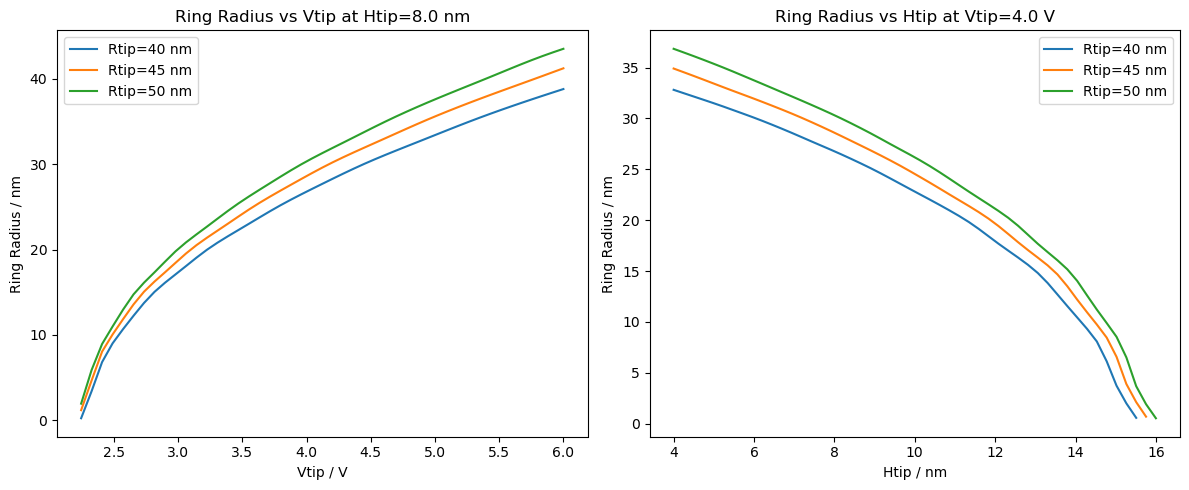

In [11]:
Rtip_targets = [40, 45, 50] # nm
Vring_target = 0.2 # V

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# axes[0]: Vtip vs ring radius at fixed Htip
# axes[1]: Htip vs ring radius at fixed Vtip
Vtip_values = np.linspace(2, 6, 50)
Vtip_fixed = 4.0 # V
Htip_values = np.linspace(4, 16, 50)
Htip_fixed = 8.0 # nm
cmap = plt.get_cmap("tab10")
data = np.nan_to_num(data, nan=0.0)
ring_radius_func = make_ring_radius_function(
    Vtip, Rtip, Htip, r, data
)
for i, Rtip_target in enumerate(Rtip_targets):
    ring_radii_Vtip = [
        ring_radius_func(Rtip_target, Vring_target, Vtip_val, Htip_fixed) for Vtip_val in Vtip_values
    ]
    ring_radii_Htip = [
        ring_radius_func(Rtip_target, Vring_target, Vtip_fixed, Htip_val) for Htip_val in Htip_values
    ]
    axes[0].plot(Vtip_values, ring_radii_Vtip, color=cmap(i), label=f"Rtip={Rtip_target} nm")
    axes[1].plot(Htip_values, ring_radii_Htip, color=cmap(i), label=f"Rtip={Rtip_target} nm")
axes[0].set_xlabel("Vtip / V")
axes[0].set_ylabel("Ring Radius / nm")
axes[0].set_title(f"Ring Radius vs Vtip at Htip={Htip_fixed} nm")
axes[0].legend()
axes[1].set_xlabel("Htip / nm")
axes[1].set_ylabel("Ring Radius / nm")
axes[1].set_title(f"Ring Radius vs Htip at Vtip={Vtip_fixed} V")
axes[1].legend()
plt.tight_layout()
plt.show()